Test MSE: 0.20
R² Score: 0.99


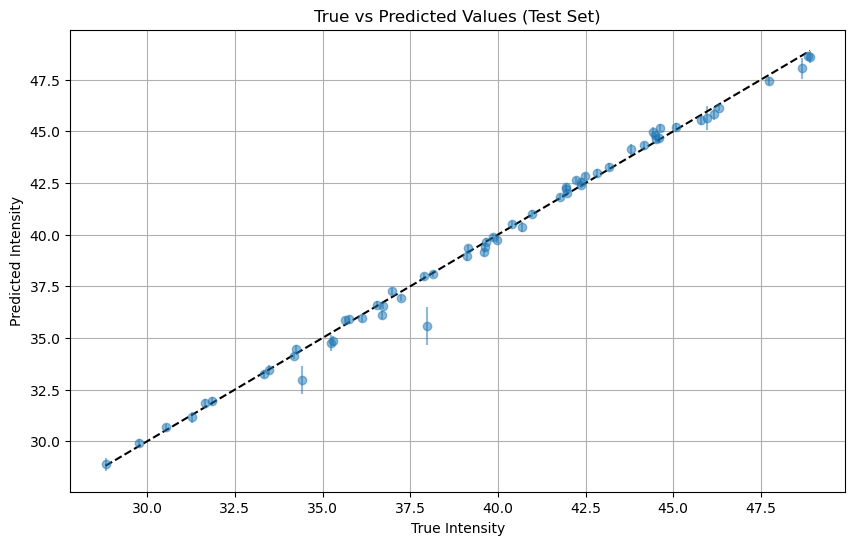

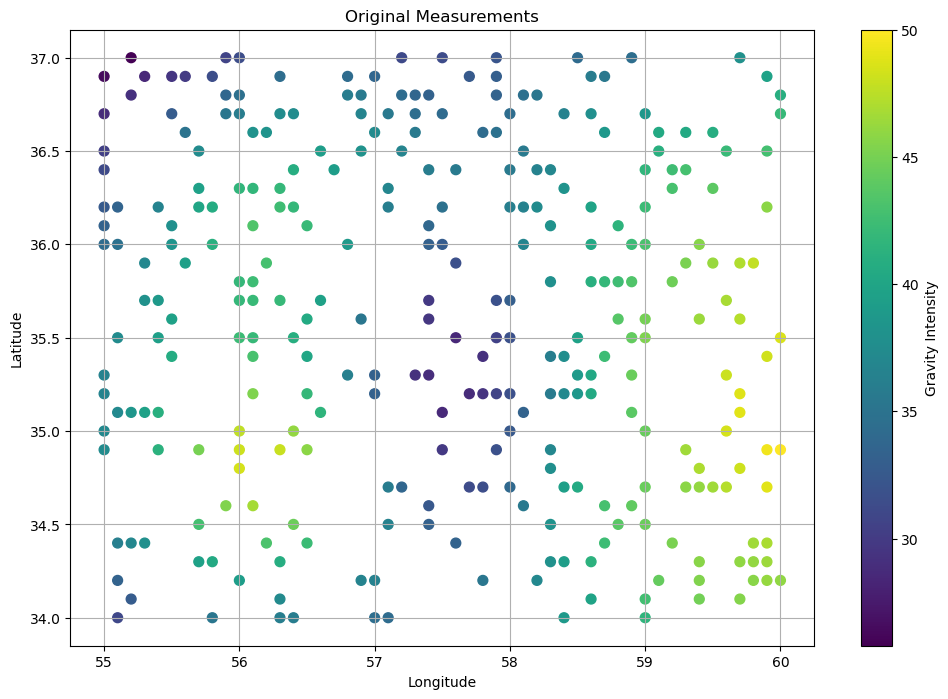

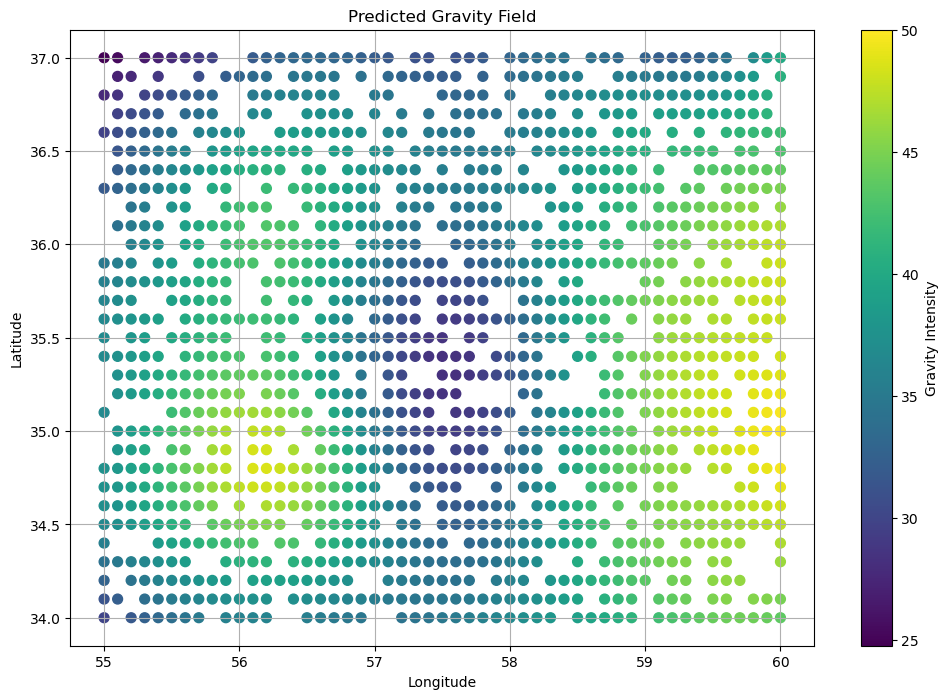

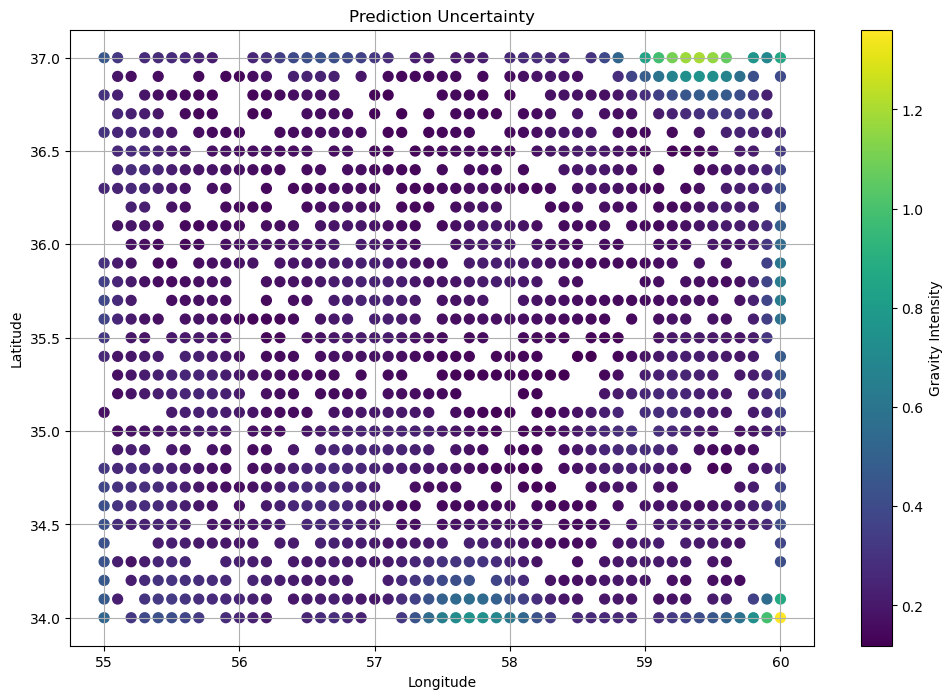

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Загрузка и подготовка данных
train_data = pd.read_csv('field_train.csv')
full_grid = pd.read_csv('field_example.csv')

# Создание матриц признаков и целевой переменной
X_train = train_data[['longitude', 'latitude']].values
y_train = train_data['intensity'].values
X_full = full_grid[['longitude', 'latitude']].values

# Нормализация данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_full_scaled = scaler.transform(X_full)

# Разделение на тренировочный и тестовый наборы (20% тестовых)
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=42
)

# Определение ядра и модели GPR
kernel = ConstantKernel(1.0) * RBF(length_scale=[0.5, 0.5])
gpr = GaussianProcessRegressor(
    kernel=kernel,
    alpha=0.1,
    n_restarts_optimizer=10,
    random_state=42
)

# Обучение модели
gpr.fit(X_train_split, y_train_split)

# Прогнозирование на тестовом наборе
y_pred_test, y_std_test = gpr.predict(X_test_split, return_std=True)

# Оценка модели
mse = mean_squared_error(y_test_split, y_pred_test)
r2 = r2_score(y_test_split, y_pred_test)
print(f"Test MSE: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

# Визуализация предсказаний на тестовых данных
plt.figure(figsize=(10, 6))
plt.errorbar(y_test_split, y_pred_test, yerr=y_std_test, fmt='o', alpha=0.5)
plt.plot([y_test_split.min(), y_test_split.max()], 
         [y_test_split.min(), y_test_split.max()], 'k--')
plt.xlabel('True Intensity')
plt.ylabel('Predicted Intensity')
plt.title('True vs Predicted Values (Test Set)')
plt.grid(True)
plt.show()

# Полное предсказание для всей сетки
full_pred, full_std = gpr.predict(X_full_scaled, return_std=True)

# Визуализация полной карты
def plot_gravity_field(coordinates, values, title):
    plt.figure(figsize=(12, 8))
    plt.scatter(coordinates[:, 0], coordinates[:, 1], c=values, 
                cmap='viridis', s=50)
    plt.colorbar(label='Gravity Intensity')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(title)
    plt.grid(True)

# Исходные измерения
plot_gravity_field(X_train, y_train, 'Original Measurements')

# Предсказанная карта
full_grid['intensity'] = full_pred
plot_gravity_field(X_full, full_pred, 'Predicted Gravity Field')

# Карта неопределенности
plot_gravity_field(X_full, full_std, 'Prediction Uncertainty')

plt.show()

# Сохранение результатов
full_grid.to_csv('predicted_gravity_field.csv', index=False)